In [2]:
import pandas as pd
import numpy as np
import scipy
from math import sqrt
import datetime
from datetime import *
from datetime import datetime as dt

import matplotlib.pyplot as plt

import itertools
import csv
from sklearn import preprocessing
from collections import Counter

#### CLUSTERING 
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import fcluster, ward, dendrogram

from operator import itemgetter
from itertools import combinations
from tqdm import tqdm

from pprint import *
#xgboost gradient boosting


#### DEFINE DATAFRAME DISPLAY OPTIONS

# Display full dataframe (without [...])
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', -1)

In [3]:
#### LOAD REDISPATCH DATASET
df_redispatch=pd.read_csv(r"C:\Users\Willem\pypsa-eur\data/redispatch_daten.csv", sep = ';', engine='python', encoding='latin-1').rename(columns={'ï»¿BEGINN_DATUM': 'BEGINN_DATUM'})

#### Necessary Preprocessing Steps in Excel
# find and replace: ä -> ae, ö -> oe, ü -> ue, ß -> ss

####

#### ADD ADDITIONAL INFO COLUMNS

# replace all non numeric (false formatted) values in MWH
for index, row in df_redispatch.iterrows():
    if type(row["GESAMTE_ARBEIT_MWH"]) == str:
        string = row["GESAMTE_ARBEIT_MWH"]
        list_ = string.split(",")
        int_ = int(list_[0])
        df_redispatch.at[index, 'GESAMTE_ARBEIT_MWH'] = int_ 
    else:
        continue
        

# add columns for ramp up only
df_redispatch["RAMP_UP"] = df_redispatch.apply(lambda x: 1 if x['RICHTUNG'] == "Wirkleistungseinspeisung erhoehen" else 0, axis=1)
df_redispatch["RAMP_UP_avg_power_MW"]=df_redispatch.apply(lambda x: x['MITTLERE_LEISTUNG_MW'] if x['RICHTUNG'] == "Wirkleistungseinspeisung erhoehen" else 0, axis=1)
df_redispatch["RAMP_UP_max_power_MW"]=df_redispatch.apply(lambda x: x['MAXIMALE_LEISTUNG_MW'] if x['RICHTUNG'] == "Wirkleistungseinspeisung erhoehen" else 0, axis=1)
df_redispatch["RAMP_UP_total_energy_MWh"]=df_redispatch.apply(lambda x: x['GESAMTE_ARBEIT_MWH'] if x['RICHTUNG'] == "Wirkleistungseinspeisung erhoehen" else 0, axis=1)

# add columns for curtailment only
df_redispatch["CURTAILMENT"]=df_redispatch.apply(lambda x: 1 if x['RICHTUNG'] == "Wirkleistungseinspeisung reduzieren" else 0, axis=1)
df_redispatch["CURTAILMENT_avg_power_MW"]=df_redispatch.apply(lambda x: x['MITTLERE_LEISTUNG_MW'] if x['RICHTUNG'] == "Wirkleistungseinspeisung reduzieren" else 0, axis=1)
df_redispatch["CURTAILMENT_max_power_MW"]=df_redispatch.apply(lambda x: x['MAXIMALE_LEISTUNG_MW'] if x['RICHTUNG'] == "Wirkleistungseinspeisung reduzieren" else 0, axis=1)
df_redispatch["CURTAILMENT_total_energy_MWh"]=df_redispatch.apply(lambda x: x['GESAMTE_ARBEIT_MWH'] if x['RICHTUNG'] == "Wirkleistungseinspeisung reduzieren" else 0, axis=1)

#### ADD REDISPATCH DURATION

# create helper dataframes (begin & end) to merge datetimeobjects
df_datetime_begin = df_redispatch[["BEGINN_DATUM","BEGINN_UHRZEIT"]].rename({'BEGINN_DATUM': 'Date', 'BEGINN_UHRZEIT': 'Time'}, axis=1)
df_datetime_begin["begin"] = pd.to_datetime(df_datetime_begin['Date'] + ' ' + df_datetime_begin['Time'])
df_datetime_end = df_redispatch[["ENDE_DATUM","ENDE_UHRZEIT"]].rename({'ENDE_DATUM': 'Date', 'ENDE_UHRZEIT': 'Time'}, axis=1)
df_datetime_end["end"] = pd.to_datetime(df_datetime_end['Date'] + ' ' + df_datetime_end['Time'])

# add datetimeobjects to df_redispatch (overwrite) and delete original columns
df_redispatch["BEGINN_DATUM"] = df_datetime_begin["begin"]
df_redispatch["ENDE_DATUM"] = df_datetime_end["end"]
df_redispatch.rename(columns={"ENDE_DATUM": "end", "BEGINN_DATUM": "begin"}, inplace = True)
df_redispatch.drop(['BEGINN_UHRZEIT',"ENDE_UHRZEIT"], axis = 1, inplace = True)

# add column for duration of redispatch operation
df_redispatch.insert(2, 'redispatch_duration', df_redispatch["end"] - df_redispatch["begin"])

# count redispatch durations in intervals 1-2-3-4-5-6-7-8-10-12-18-24 hours
df_redispatch["longer than 24 h"] = df_redispatch.apply(lambda x: 1 if x["redispatch_duration"] > timedelta(hours=24) else 0, axis = 1)
df_redispatch["between 18 h and 24 h"] = df_redispatch.apply(lambda x: 1 if (x["redispatch_duration"] <= timedelta(hours=24) and x["redispatch_duration"] > timedelta(hours=18)) else 0, axis = 1)
df_redispatch["between 12 h and 18 h"] = df_redispatch.apply(lambda x: 1 if (x["redispatch_duration"] <= timedelta(hours=18) and x["redispatch_duration"] > timedelta(hours=12)) else 0, axis = 1)
df_redispatch["between 10 h and 12 h"] = df_redispatch.apply(lambda x: 1 if (x["redispatch_duration"] <= timedelta(hours=12) and x["redispatch_duration"] > timedelta(hours=10)) else 0, axis = 1)
df_redispatch["between 9 h and 10 h"] = df_redispatch.apply(lambda x: 1 if (x["redispatch_duration"] <= timedelta(hours=10) and x["redispatch_duration"] > timedelta(hours=9)) else 0, axis = 1)
df_redispatch["between 8 h and 9 h"] = df_redispatch.apply(lambda x: 1 if (x["redispatch_duration"] <= timedelta(hours=9) and x["redispatch_duration"] > timedelta(hours=8)) else 0, axis = 1)
df_redispatch["between 7 h and 8 h"] = df_redispatch.apply(lambda x: 1 if (x["redispatch_duration"] <= timedelta(hours=8) and x["redispatch_duration"] > timedelta(hours=7)) else 0, axis = 1)
df_redispatch["between 6 h and 7 h"] = df_redispatch.apply(lambda x: 1 if (x["redispatch_duration"] <= timedelta(hours=7) and x["redispatch_duration"] > timedelta(hours=6)) else 0, axis = 1)
df_redispatch["between 5 h and 6 h"] = df_redispatch.apply(lambda x: 1 if (x["redispatch_duration"] <= timedelta(hours=6) and x["redispatch_duration"] > timedelta(hours=5)) else 0, axis = 1)
df_redispatch["between 4 h and 5 h"] = df_redispatch.apply(lambda x: 1 if (x["redispatch_duration"] <= timedelta(hours=5) and x["redispatch_duration"] > timedelta(hours=4)) else 0, axis = 1)
df_redispatch["between 3 h and 4 h"] = df_redispatch.apply(lambda x: 1 if (x["redispatch_duration"] <= timedelta(hours=4) and x["redispatch_duration"] > timedelta(hours=3)) else 0, axis = 1)
df_redispatch["between 2 h and 3 h"] = df_redispatch.apply(lambda x: 1 if (x["redispatch_duration"] <= timedelta(hours=3) and x["redispatch_duration"] > timedelta(hours=2)) else 0, axis = 1)
df_redispatch["between 1 h and 2 h"] = df_redispatch.apply(lambda x: 1 if (x["redispatch_duration"] <= timedelta(hours=2) and x["redispatch_duration"] > timedelta(hours=1)) else 0, axis = 1)
df_redispatch["under 1 h"] = df_redispatch.apply(lambda x: 1 if (x["redispatch_duration"] <= timedelta(hours=1) and x["redispatch_duration"] > timedelta(hours=0)) else 0, axis = 1)
df_redispatch["< 0 (False)"] = df_redispatch.apply(lambda x: 1 if (x["redispatch_duration"] < timedelta(hours=0)) else 0, axis = 1)

# remove rows where redispatch duration is negative
df_redispatch = df_redispatch.drop(df_redispatch[df_redispatch["< 0 (False)"] == 1].index)
#print(df_redispatch["< 0 (False)"].sum())
print(len(df_redispatch.index))
display(df_redispatch)

15874


,begin,end,redispatch_duration,NETZREGION,GRUND_DER_MASSNAHME,RICHTUNG,MITTLERE_LEISTUNG_MW,MAXIMALE_LEISTUNG_MW,GESAMTE_ARBEIT_MWH,ANWEISENDER_UENB,ANFORDERNDER_UENB,BETROFFENE_ANLAGE,RAMP_UP,RAMP_UP_avg_power_MW,RAMP_UP_max_power_MW,RAMP_UP_total_energy_MWh,CURTAILMENT,CURTAILMENT_avg_power_MW,CURTAILMENT_max_power_MW,CURTAILMENT_total_energy_MWh,longer than 24 h,between 18 h and 24 h,between 12 h and 18 h,between 10 h and 12 h,between 9 h and 10 h,between 8 h and 9 h,between 7 h and 8 h,between 6 h and 7 h,between 5 h and 6 h,between 4 h and 5 h,between 3 h and 4 h,between 2 h and 3 h,between 1 h and 2 h,under 1 h,< 0 (False)
0,2014-12-31 00:00:00,2015-01-01 00:00:00,1 days 00:00:00,RZ TenneT DE,Strombedingter Redispatch,Wirkleistungseinspeisung erhoehen,121,200,2900,TransnetBW,TenneT DE,Grosskraftwerk Mannheim AG,1,121,200,2900,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2014-12-31 00:00:00,2015-01-01 00:00:00,1 days 00:00:00,RZ TenneT DE,Strombedingter Redispatch,Wirkleistungseinspeisung erhoehen,103,125,2475,TransnetBW,TenneT DE,Heizkraftwerk Heilbronn,1,103,125,2475,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2014-12-31 00:00:00,2015-01-01 00:00:00,1 days 00:00:00,RZ TenneT DE,Strombedingter Redispatch,Wirkleistungseinspeisung erhoehen,103,125,2475,TransnetBW,TenneT DE,Heizkraftwerk Heilbronn,1,103,125,2475,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2014-12-31 06:00:00,2015-01-01 00:00:00,0 days 18:00:00,Grenzregion RZ 50Hertz - RZ TenneT DE,Strombedingter Redispatch,Wirkleistungseinspeisung erhoehen,235,300,4225,TenneT DE,50Hertz & TenneT DE,Gebersdorf 2,1,235,300,4225,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,2014-12-31 22:00:00,2015-01-01 00:00:00,0 days 02:00:00,RZ TenneT DE,Strombedingter Redispatch,Wirkleistungseinspeisung erhoehen,50,50,100,TransnetBW,TenneT DE,Vorarlberger Illwerke AG,1,50,50,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16119,2017-12-30 17:00:00,2017-12-30 20:00:00,0 days 03:00:00,"RZ 50Hertz, RZ Amprion, RZ TenneT DE, RZ Trans...",Strombedingter Redispatch,Wirkleistungseinspeisung reduzieren,83,100,250,TenneT DE,50Hertz & Amprion & TenneT DE & TransnetBW,Brokdorf,0,0,0,0,1,83,100,250,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
16120,2017-12-30 23:45:00,2017-12-31 00:00:00,0 days 00:15:00,RZ APG,Strombedingter Redispatch,Wirkleistungseinspeisung reduzieren,150,150,37,TransnetBW,APG,Kernkraftwerk Neckarwestheim Block 2,0,0,0,0,1,150,150,37,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
16121,2017-12-31 00:00:00,2017-12-31 17:15:00,0 days 17:15:00,RZ APG,Strombedingter Redispatch,Wirkleistungseinspeisung reduzieren,"297,83",300,5137,TransnetBW,APG,Kernkraftwerk Neckarwestheim Block 2,0,0,0,0,1,"297,83",300,5137,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
16122,2017-12-31 00:00:00,2017-12-31 17:00:00,0 days 17:00:00,RZ APG,Strombedingter Redispatch,Wirkleistungseinspeisung reduzieren,100,100,1700,TransnetBW,APG,Kernkraftwerk Philippsburg Block 2,0,0,0,0,1,100,100,1700,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
#### ANALZYE GLOBAL POWERPLANT DATABASE & REDISPATCH POWER PLANTS

#### Necessary Preprocessing Steps in Excel
# none. Ä,ö,ü already transformed into weird fail symbols within the input dataset 

df_powerplant_data=pd.read_csv(r"C:\Users\Willem\pypsa-eur\data/global_power_plant_database.csv", sep = ',', engine='python', encoding='latin-1')

# Only keep Powerplants in Germany, only keep name, fuel, capacity, and coordinates columns
df_powerplant_data = df_powerplant_data.drop(df_powerplant_data[df_powerplant_data["country"] != "DEU"].index).reset_index(drop=True)
df_powerplant_data = df_powerplant_data[["name", "capacity_mw", "latitude", "longitude","primary_fuel"]]   
print(df_powerplant_data.primary_fuel.unique())

# Dataframe only with conventional Generation (for pandas logic operations use "&" instead of "and", and "|" instead of "or")
df_powerplant_data_conv = df_powerplant_data.drop(df_powerplant_data[(df_powerplant_data["primary_fuel"] == "Solar") | 
                                                                     (df_powerplant_data["primary_fuel"] == "Wind")].index).reset_index(drop=True)
#display(df_powerplant_data_conv)

# Create dfs of all Powerplant names by generation source
df_powerplant_data_hydro =  df_powerplant_data_conv.drop(df_powerplant_data_conv[df_powerplant_data_conv["primary_fuel"] != "Hydro"].index)
df_powerplant_data_gas = df_powerplant_data_conv.drop(df_powerplant_data_conv[df_powerplant_data_conv["primary_fuel"] != "Gas"].index)
df_powerplant_data_coal = df_powerplant_data_conv.drop(df_powerplant_data_conv[df_powerplant_data_conv["primary_fuel"] != "Coal"].index)
df_powerplant_data_oil = df_powerplant_data_conv.drop(df_powerplant_data_conv[df_powerplant_data_conv["primary_fuel"] != "Oil"].index)
df_powerplant_data_nuclear = df_powerplant_data_conv.drop(df_powerplant_data_conv[df_powerplant_data_conv["primary_fuel"] != "Nuclear"].index)

# Create df of powerplant names by  and y values
df_powerplant_data_loc =  df_powerplant_data_conv.drop(["capacity_mw","primary_fuel"], axis = 1)

# Remove unwanted strings for comparison
list_removeStrings = [r' power station','Kraftwerk ',r'Netzreservekraftwerk ',r'FHKW ',r'HKW ',r'GKH ',r'GKM ',
                     r'Gemeinschaftskraftwerk ',r'GuD ',r'PSW ',r'PKV ',r' (Oil)',r'Pumpspeicherkraftwerk ',r"Heizkraftwerk ",
                     r' (SWM)',r' (Natural Gas)',r' (Coal)',r'GMVA ',r'GTKW ']
for i in list_removeStrings:
    df_powerplant_data_loc["name"] = df_powerplant_data_loc["name"].str.replace(i, '')

display(df_powerplant_data_loc)

# Export as excel for manual comparison
df_powerplant_data_loc.to_csv(r"C:\Users\Willem\pypsa-eur\data/powerplant_data_location.csv", sep=';')

['Gas' 'Waste' 'Solar' 'Coal' 'Hydro' 'Wind' 'Oil' 'Biomass' 'Nuclear'
 'Other']


,name,latitude,longitude
0,ADS-Anlage,50.0918,8.5311
1,ANeunkirchen,49.3386,7.1700
2,AMK - Abfallentsorgungsgesellschaft des MÃ¤rki...,51.3971,7.6967
3,AVA GmbH,48.4011,10.9356
4,AVA Velsen,49.2139,6.8345
...,...,...,...
544,ZWSF,52.5350,12.3626
545,Zellstoff Stendal GmbH,52.7271,12.0112
546,Zeltingen,49.9511,7.0232
547,Zielitz,52.2985,11.6796


In [5]:
#### ANALZYE REDISPATCH POWER PLANTS

# Get Pandas Dataframe column of all unique Powerplant Names to check their energy carriers
cols = list(df_redispatch)
cols.remove("BETROFFENE_ANLAGE")
df_generation_source = df_redispatch.drop(df_redispatch[cols],axis=1,inplace=False).dropna(axis=0)
df_generation_source.drop_duplicates(subset=None,inplace=True,keep="first")

# Divide the redispatch operations of several powerplants into the unique powerplants
list_powerplants = list(itertools.chain.from_iterable(df_generation_source.values.tolist()))
print(type(list_powerplants[1]))
for i in range(len(list_powerplants)):
    list_powerplants[i] = list_powerplants[i].split(",")

    for j in range(len(list_powerplants[i])):
        list_powerplants[i][j] = list_powerplants[i][j].strip()

df_powerplants = pd.DataFrame(list(itertools.chain.from_iterable(list_powerplants)),columns=['Powerplant'])
df_powerplants.drop_duplicates(subset=None,inplace=True,keep="first")
df_powerplants.reset_index(inplace=True)
df_powerplants.drop(['index'],axis=1,inplace=True)

####

# Get another powerplants 2-column dataframe for energy carriers
df_powerplants_energy = df_powerplants.copy()
df_powerplants_energy["energy_carrier"] = 0

# Create powerplant dictionary out of 2 column powerplant df
dict_powerplants_energy = dict(zip(df_powerplants_energy.Powerplant, df_powerplants_energy.energy_carrier))

# Update the powerplant dict with respective energy carrier
dict_powerplants_energy.update({'': 0,
                         '10YDE-RWENET---I': "load shedding",
                         'Abschaltbare Last (RZ TenneT DE)': "load shedding",
                         'Amprion Abruf abschaltbare Lasten': "load shedding",
                         'Amprion NR BK': "market",
                         'Auslaendische-Netzreserve': "market",
                         'BASF KW-Park': "gas",
                         'Bergkamen': "coal",
                         'Bexbach': "coal",
                         'Boxberg': "lignite",
                         'Bremen 15': "coal",
                         'Bremen 5': "coal",
                         'Bremen 6': "coal",
                         'Bremen GKB': "gas",
                         'Brokdorf': "nuclear",
                         'Brokdorf (EON)': "nuclear",
                         'Buschhaus': "lignite",
                         'CB-Redispatch': "load shedding",
                         'EGC KW-Pool': "market",
                         'Emden 4 GT': "gas",
                         'Emsland': "nuclear",
                         'Emsland KKE': "nuclear",
                         'Ensdorf': "coal",
                         'Erzhausen 1': "pumped hydro",
                         'Erzhausen 2': "pumped hydro",
                         'Erzhausen 3': "pumped hydro",
                         'Erzhausen 4': "pumped hydro",
                         'Farge': "coal",
                         'Frankfurt West 2': "coal",
                         'Frankfurt West 3': "coal",
                         'Frankfurt West 4': "gas",
                         'Freimann GT 1': "gas",
                         'GDF Suez KW-Pool': "market",
                         'GK-West': "coal",
                         'GTKW Darmstadt': "gas",
                         'Gebersdorf 1': "gas",
                         'Gebersdorf 2': "gas",
                         'Gebersdorf GT': "gas",
                         'Gersteinwerk': "gas",
                         'Goldisthal': "pumped hydro",
                         'Grohnde': "nuclear",
                         'Grosskraftwerk Mannheim AG': "coal",
                         'Gundremmingen': "nuclear",
                         'Gundremmingen B (EON)': "nuclear",
                         'Hamm Uentrop': "gas",
                         'Hannover (GKH) 1': "coal",
                         'Heizkraftwerk Altbach/Deizisau': "coal",
                         'Heizkraftwerk Altbach/Deizisau Block 1': "coal",
                         'Heizkraftwerk Altbach/Deizisau Block 2': "gas",
                         'Heizkraftwerk Altbach/Deizisau GT A': "gas",
                         'Heizkraftwerk Altbach/Deizisau GT B': "gas",
                         'Heizkraftwerk Altbach/Deizisau GT C': "gas",
                         'Heizkraftwerk Altbach/Deizisau GT E': "gas",
                         'Heizkraftwerk Heilbronn': "coal",
                         'Heizkraftwerk Heilbronn Block 7': "coal",
                         'Heizkraftwerk Stuttgart-Muenster': "gas",
                         'Heizkraftwerk Stuttgart-Muenster GT': "gas",
                         'Herne': "coal",
                         'Heyden': "coal",
                         'Hohenwarte 2': "pumped hydro",
                         'Hohewarte II': "pumped hydro",
                         'Huntorf': "gas",
                         'Ibbenbueren': "coal",
                         'Ingolstadt 3': "oil",
                         'Ingolstadt 4': "oil",
                         'Irsching 4': "gas",
                         'Irsching 5': "gas",
                         'Isar 2 (EON)': "nuclear",
                         'Isar 2 (SWM)': "nuclear",
                         'Isar 2 (Uniper)': "nuclear",
                         'Jaenschwalde': "lignite",
                         'KW Grohnde': "nuclear",
                         'KWNIEHL': "gas",
                         'Kernkraftwerk Neckarwestheim': "nuclear",
                         'Kernkraftwerk Neckarwestheim Block 2': "nuclear",
                         'Kernkraftwerk Philippsburg': "nuclear",
                         'Kernkraftwerk Philippsburg Block 2': "nuclear",
                         'Kiel': "coal",
                         'Kirchlengern GT 1': "gas",
                         'Knapsack': "gas",
                         'Kraftwerk Lippendorf': "lignite",
                         'Kraftwerk Mainz Wiesbaden': "gas",
                         'Kraftwerk Walheim': "oil",
                         'Kraftwerk Walheim GT D': "oil",
                         'Kuehtai 1 (Uniper)': "hydro",
                         'Kuehtai 2 (Uniper)': "pumped hydro",
                         'Leitzach 1 M11': "pumped hydro",
                         'Linden GKL GT 1': "gas",
                         'Linden GKL GT 3': "gas",
                         'Lippendorf': "lignite",
                         'Lippendorf (EnBW)': "lignite",
                         'Lippendorf EnBW': "lignite",
                         'Lippendorf EnbW': "lignite",
                         'Lippendorf VE': "lignite",
                         'Lippendorf Vattenfall': "lignite",
                         'Lippendorf Vattenfall (EPH)': "lignite",
                         'Luenen': "coal",
                         'MRL BK TransnetBW': "market",
                         'Markersbach': "pumped hydro",
                         'Markesbach': "pumped hydro",
                         'Mehrum': "coal",
                         'Moorburg': "coal",
                         'Muenchen Nord 2': "coal",
                         'Muenchen Sued GT 2': "gas",
                         'Muenchen Sued GT 3': "gas",
                         'Muenchen Sued GT 61': "gas",
                         'Muenchen Sued GT 62': "gas",
                         'Netzreservekraftwerk Bexbach': "coal",
                         'Netzreservekraftwerk Darmstadt': "gas",
                         'Netzreservekraftwerk KMW 2': "gas",
                         'Netzreservekraftwerk Weiher': "coal",
                         'Neurath': "lignite",
                         'NiederauÃ\x9fem': "lignite",
                         'Niederrad 1': "coal",
                         'Niederrad 2': "coal",
                         'Obernburg': "gas" ,
                         'Pumpspeicherwerk Glems': "pumped hydro",
                         'Pumpspeicherwerk Schluchseegruppe RZ TNG': "pumped hydro",
                         'Pumpspeicherwerk Wehr RZ TNG': "pumped hydro",
                         'Redispatch BK': "market",
                         'Redispatch DE<>CH: Vertrag ID': "market",
                         'Reisach 1': "pumped hydro",
                         'Reisach 2': "pumped hydro",
                         'Reisach 3': "pumped hydro",
                         'Reservekraftwerk Heilbronn': "coal",
                         'Reservekraftwerk Heilbronn Block 5': "coal",
                         'Reservekraftwerk Heilbronn Block 6': "coal",
                         'Reservekraftwerk Ingolstadt 3': "oil",
                         'Reservekraftwerk Ingolstadt 4': "oil",
                         'Reservekraftwerk Irsching 3': "gas",
                         'Reservekraftwerk Irsching 4': "gas",
                         'Reservekraftwerk Irsching 5': "gas",
                         'Reservekraftwerk Marbach': "oil",
                         'Reservekraftwerk Marbach DT 3': "oil",
                         'Reservekraftwerk Marbach GT 2': "oil",
                         'Reservekraftwerk Marbach GT 3': "oil",
                         'Reservekraftwerk Staudinger 4': "gas",
                         'Reservekraftwerk Walheim': "oil",
                         'Reservekraftwerk Walheim Block 1': "oil",
                         'Reservekraftwerk Walheim Block 2': "oil",
                         'Reuter': "coal",
                         'Rheinhafen-Dampfkraftwerk Karlsruhe': "coal",
                         'Rheinhafen-Dampfkraftwerk Karlsruhe Block 4': "coal",
                         'Rheinhafen-Dampfkraftwerk Karlsruhe Block 7': "gas",
                         'Rheinhafen-Dampfkraftwerk Karlsruhe Block 8': "coal",
                         'Robert Frank 4 GT': "gas",
                         'Roemerbruecke Heizkraftwerk': "gas",
                         'Rostock': "coal",
                         'SW Hannover KW-Pool': "coal",
                         'SW Muenchen KW-Pool': "pumped hydro",
                         'Schkopau': "lignite",
                         'Schluchseewerk AG': "pumped hydro",
                         'Scholven': "coal",
                         'Schwarze Pumpe': "lignite",
                         'Silz 1 (EON)': "pumped hydro",
                         'Silz 1 (Uniper)': "pumped hydro",
                         'Silz 2 (Uniper)': "pumped hydro",
                         'Statkraft KW-Pool': "gas",
                         'Staudinger 5': "coal",
                         'Stummhafen': "coal",
                         'Tanzmuehle': "pumped hydro",
                         'Voelklingen HKV': "coal",
                         'Voelklingen MKV': "gas",
                         'Voerde': "coal",
                         'Vorarlberger Illwerke AG': "pumped hydro",
                         'Waldeck 1': "pumped hydro",
                         'Waldeck 3': "pumped hydro",
                         'Waldeck 4': "pumped hydro",
                         'Waldeck 5': "pumped hydro",
                         'Waldeck 6': "pumped hydro",
                         'Walsum': "coal",
                         'Wehr': "pumped hydro",
                         'Weiher': "coal",
                         'Weisweiler': "lignite",
                         'Westfalen': "coal",
                         'Wilhelmshaven (ENGIE)': "coal",
                         'Wilhelmshaven (EON)': "coal",
                         'Wilhelmshaven (GDF)': "coal",
                         'Wilhelmshaven (Uniper)': "coal",
                         'Wolfsburg West 1': "coal",
                         'Wolfsburg West 2': "coal",
                         'Wuerzburg GT 1': "gas",
                         'Zolling 5': "biomass",
                         'Zolling GT 1': "gas",
                         'Zolling GT 2': "gas",
                         'auslaendische-Netzreserve': "market"})
Count_Powerplants = Counter(dict_powerplants_energy.values())
pprint(Count_Powerplants)

# comments on the energy carriers: 
# - Kiel = Küstenkraftwerk Kiel. Bis 2019 Steinkohle, ab 2019 gasturbine
# - 'Kraftwerk Walheim': "oil" ist auch steinkohle, aber für redispatch ramp up ist turbine wahrscheinlicher
# - 'Netzreservekraftwerk KMW 2' = Kraftwerk Mainz Wiesbaden
# - 'SW Muenchen KW-Pool': "pumped hydro", da Annahme dass es sich hier um das Virtuelle kraftwerk der stadtwerke münchen handelt

####

#### ISOLATE THE ENERGY CARRIERS TO ADD THEM TO THE REDISPATCH DATA

df_powerplants_energy = pd.DataFrame.from_dict(dict_powerplants_energy, orient = "index").rename(columns={0: "energy_carrier"})

# create lookup list for each energy carrier
list_coal = []
list_lignite = []
list_gas = []
list_pumped_hydro = []
list_nuclear = []
list_oil = []
list_market = []
list_hydro = []
list_load_shedding = []

# fill the lookup lists
for index, row in df_powerplants_energy.iterrows():
    if row["energy_carrier"] == "coal":
        list_coal.append(row.name)
    elif row["energy_carrier"] == "lignite":
        list_lignite.append(row.name)
    elif row["energy_carrier"] == "gas":
        list_gas.append(row.name)
    elif row["energy_carrier"] == "pumped hydro":
        list_pumped_hydro.append(row.name)
    elif row["energy_carrier"] == "nuclear":
        list_nuclear.append(row.name)
    elif row["energy_carrier"] == "oil":
        list_oil.append(row.name)
    elif row["energy_carrier"] == "market":
        list_market.append(row.name)
    elif row["energy_carrier"] == "hydro":
        list_hydro.append(row.name)
    elif row["energy_carrier"] == "load shedding":
        list_load_shedding.append(row.name)
    else:
        continue
print(list_coal)

# add empty columns for the energy carriers
df_redispatch = df_redispatch.reindex(columns = df_redispatch.columns.tolist() + ['coal','lignite',"gas","pumped hydro","nuclear","oil","market","hydro","load shedding"])
#df_redispatch[['coal','lignite',"gas","pumped hydro","nuclear","oil","market","hydro","load shedding"]] = df_redispatch[['coal','lignite',"gas","pumped hydro","nuclear","oil","market","hydro","load shedding"]].fillna(0)
df_redispatch.iloc[:,-9:] = df_redispatch.iloc[:,-9:].fillna(0)

####

#### ADD ENERGY CARRIERS OF THE USED POWERPLANTS TO EVERY REDISPATCH OPERATION

# create a copy df for further operations
df_rd = df_redispatch.copy().reset_index(drop=True)

# preprocess df_redispatch for lookup operation
# fill NaN cells
for index, row in df_rd.iterrows():
    if type(row["BETROFFENE_ANLAGE"]) != str:
        df_rd.at[index, 'BETROFFENE_ANLAGE'] = "unknown"
    else:
        continue

# split strings of several redispatch power plants
for index, row in df_rd.iterrows():
    plant_list = row["BETROFFENE_ANLAGE"].split(",") 
    #print(row.name)
    for i in range(len(plant_list)):
        #print(plant_list)
        plant_list[i] = plant_list[i].strip()
        
    #df_rd.loc[index,"BETROFFENE_ANLAGE"] = plant_list
    df_rd.at[index, 'BETROFFENE_ANLAGE'] = plant_list
    

# Fill energy carrier columns: Check elements if each lists of powerplants within each cell is in lookup list for specific energy carrier
for index, row in df_rd.iterrows(): 
    for i in range(len(row["BETROFFENE_ANLAGE"])):
        if row["BETROFFENE_ANLAGE"][i] in list_coal:
            df_rd.at[index, 'coal'] = 1
        elif row["BETROFFENE_ANLAGE"][i] in list_lignite:
            df_rd.at[index, 'lignite'] = 1
        elif row["BETROFFENE_ANLAGE"][i] in list_gas:
            df_rd.at[index, 'gas'] = 1
        elif row["BETROFFENE_ANLAGE"][i] in list_pumped_hydro:
            df_rd.at[index, 'pumped hydro'] = 1
        elif row["BETROFFENE_ANLAGE"][i] in list_hydro:
            df_rd.at[index, 'hydro'] = 1
        elif row["BETROFFENE_ANLAGE"][i] in list_nuclear:
            df_rd.at[index, 'nuclear'] = 1
        elif row["BETROFFENE_ANLAGE"][i] in list_oil:
            df_rd.at[index, 'oil'] = 1
        elif row["BETROFFENE_ANLAGE"][i] in list_market:
            df_rd.at[index, 'market'] = 1
        elif row["BETROFFENE_ANLAGE"][i] in list_load_shedding:
            df_rd.at[index, 'load shedding'] = 1
        else:
            continue

display(df_rd)

<class 'str'>
Counter({'coal': 51,
         'gas': 46,
         'pumped hydro': 30,
         'lignite': 16,
         'nuclear': 15,
         'oil': 13,
         'market': 8,
         'load shedding': 4,
         'biomass': 1,
         0: 1,
         'hydro': 1})
['Grosskraftwerk Mannheim AG', 'Heizkraftwerk Heilbronn', 'Heizkraftwerk Altbach/Deizisau', 'Moorburg', 'Rheinhafen-Dampfkraftwerk Karlsruhe', 'Wilhelmshaven (EON)', 'Rostock', 'Kiel', 'Bergkamen', 'Farge', 'Mehrum', 'Walsum', 'Niederrad 1', 'Frankfurt West 3', 'Frankfurt West 2', 'Niederrad 2', 'Herne', 'Voelklingen HKV', 'Bexbach', 'Staudinger 5', 'GK-West', 'Weiher', 'Heyden', 'Wilhelmshaven (GDF)', 'Luenen', 'Scholven', 'Voerde', 'Stummhafen', 'Ibbenbueren', 'Hannover (GKH) 1', 'Muenchen Nord 2', 'SW Hannover KW-Pool', 'Ensdorf', 'Bremen 5', 'Reservekraftwerk Heilbronn', 'Westfalen', 'Wilhelmshaven (Uniper)', 'Reuter', 'Bremen 6', 'Heizkraftwerk Heilbronn Block 7', 'Rheinhafen-Dampfkraftwerk Karlsruhe Block 8', 'Rheinhafen-

,begin,end,redispatch_duration,NETZREGION,GRUND_DER_MASSNAHME,RICHTUNG,MITTLERE_LEISTUNG_MW,MAXIMALE_LEISTUNG_MW,GESAMTE_ARBEIT_MWH,ANWEISENDER_UENB,ANFORDERNDER_UENB,BETROFFENE_ANLAGE,RAMP_UP,RAMP_UP_avg_power_MW,RAMP_UP_max_power_MW,RAMP_UP_total_energy_MWh,CURTAILMENT,CURTAILMENT_avg_power_MW,CURTAILMENT_max_power_MW,CURTAILMENT_total_energy_MWh,longer than 24 h,between 18 h and 24 h,between 12 h and 18 h,between 10 h and 12 h,between 9 h and 10 h,between 8 h and 9 h,between 7 h and 8 h,between 6 h and 7 h,between 5 h and 6 h,between 4 h and 5 h,between 3 h and 4 h,between 2 h and 3 h,between 1 h and 2 h,under 1 h,< 0 (False),coal,lignite,gas,pumped hydro,nuclear,oil,market,hydro,load shedding
0,2014-12-31 00:00:00,2015-01-01 00:00:00,1 days 00:00:00,RZ TenneT DE,Strombedingter Redispatch,Wirkleistungseinspeisung erhoehen,121,200,2900,TransnetBW,TenneT DE,[Grosskraftwerk Mannheim AG],1,121,200,2900,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2014-12-31 00:00:00,2015-01-01 00:00:00,1 days 00:00:00,RZ TenneT DE,Strombedingter Redispatch,Wirkleistungseinspeisung erhoehen,103,125,2475,TransnetBW,TenneT DE,[Heizkraftwerk Heilbronn],1,103,125,2475,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2014-12-31 00:00:00,2015-01-01 00:00:00,1 days 00:00:00,RZ TenneT DE,Strombedingter Redispatch,Wirkleistungseinspeisung erhoehen,103,125,2475,TransnetBW,TenneT DE,[Heizkraftwerk Heilbronn],1,103,125,2475,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2014-12-31 06:00:00,2015-01-01 00:00:00,0 days 18:00:00,Grenzregion RZ 50Hertz - RZ TenneT DE,Strombedingter Redispatch,Wirkleistungseinspeisung erhoehen,235,300,4225,TenneT DE,50Hertz & TenneT DE,[Gebersdorf 2],1,235,300,4225,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2014-12-31 22:00:00,2015-01-01 00:00:00,0 days 02:00:00,RZ TenneT DE,Strombedingter Redispatch,Wirkleistungseinspeisung erhoehen,50,50,100,TransnetBW,TenneT DE,[Vorarlberger Illwerke AG],1,50,50,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15869,2017-12-30 17:00:00,2017-12-30 20:00:00,0 days 03:00:00,"RZ 50Hertz, RZ Amprion, RZ TenneT DE, RZ Trans...",Strombedingter Redispatch,Wirkleistungseinspeisung reduzieren,83,100,250,TenneT DE,50Hertz & Amprion & TenneT DE & TransnetBW,[Brokdorf],0,0,0,0,1,83,100,250,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
15870,2017-12-30 23:45:00,2017-12-31 00:00:00,0 days 00:15:00,RZ APG,Strombedingter Redispatch,Wirkleistungseinspeisung reduzieren,150,150,37,TransnetBW,APG,[Kernkraftwerk Neckarwestheim Block 2],0,0,0,0,1,150,150,37,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
15871,2017-12-31 00:00:00,2017-12-31 17:15:00,0 days 17:15:00,RZ APG,Strombedingter Redispatch,Wirkleistungseinspeisung reduzieren,"297,83",300,5137,TransnetBW,APG,[Kernkraftwerk Neckarwestheim Block 2],0,0,0,0,1,"297,83",300,5137,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
15872,2017-12-31 00:00:00,2017-12-31 17:00:00,0 days 17:00:00,RZ APG,Strombedingter Redispatch,Wirkleistungseinspeisung reduzieren,100,100,1700,TransnetBW,APG,[Kernkraftwerk Philippsburg Block 2],0,0,0,0,1,100,100,1700,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [6]:
# Analyze unique location & frequency of redispatch operations
S = df_rd["RICHTUNG"].value_counts()
LL = (df_rd["lignite"]*df_rd["CURTAILMENT"])
print(LL)
LL.sum()

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
15869    0.0
15870    0.0
15871    0.0
15872    0.0
15873    0.0
Length: 15874, dtype: float64


3808.0

In [7]:
#### GENERATE DATAFRAME FOR ANALYSES FOR EACH ENERGY CARRIER

# create list of coluns
cols_carrier = list(df_rd.iloc[:,-9:].copy())
cols_time = list(df_rd.iloc[:,-24:-10].copy())

# empty dicts for relevant sum's
dict_sum = {}
dict_sum_rampUp = {}
dict_sum_curtail = {}
dict_sum_energy = {}
dict_sum_enery_rampUp = {}
dict_sum_energy_curtail = {}

dict_sum_carrier_times= {}
dict_sum_carrier_rampUp_times = {}
dict_sum_carrier_curtail_times = {}

####

# dict with sum of # redispatch by energy carrier
for i in cols_carrier:
    dict_sum.update({i : df_rd[i].sum()}) 

# dict with sum of # positive redispatch by energy carrier
for i in cols_carrier:
    dict_sum_rampUp.update({i : df_rd.loc[df_rd["RAMP_UP"] == 1, i].sum()})

# dict with sum of # negative redispatch by energy carrier
for i in cols_carrier:
    dict_sum_curtail.update({i : df_rd.loc[df_rd["RAMP_UP"] == 0, i].sum()})

# dict with sum of total redispatch energy by energy carrier
for i in cols_carrier:
    dict_sum_energy.update({i : (df_rd[i]*df_rd["GESAMTE_ARBEIT_MWH"]).sum()})

# dict with sum of total ramp up energy by energy carrier (load shedding => less load at same generation => treated as 
for i in cols_carrier:
    dict_sum_enery_rampUp.update({i : (df_rd[i]*df_rd["RAMP_UP_total_energy_MWh"]).sum()})

# dict with sum of total curtailment energy by energy carrier
for i in cols_carrier:
    dict_sum_energy_curtail.update({i : (df_rd[i]*df_rd["CURTAILMENT_total_energy_MWh"]).sum()})   

####
    
# dicts with sum of # of redispatch times by energy carrier
for y in cols_time:
    dict_carrier = {}    
    # inner for loop iterates through the energy carriers
    for i in cols_carrier:
        dict_carrier.update({i : (df_rd[i]*df_rd[y]).sum()})
    dict_sum_carrier_times.update({y : dict_carrier})
#pprint(dict_sum_carrier_times)

# dicts with sum of # of ramp up times by energy carrier
for y in cols_time:
    dict_carrier_ramp = {}
    for i in cols_carrier:
        dict_carrier_ramp.update({i : (df_rd[i]*df_rd[y]*df_rd["RAMP_UP"]).sum()})
    dict_sum_carrier_rampUp_times.update({y : dict_carrier_ramp})

# dicts with sum of # of curtailment times by energy carrier
for y in cols_time:
    dict_carrier_curtail = {}
    for i in cols_carrier:
        dict_carrier_curtail.update({i : (df_rd[i]*df_rd[y]*df_rd["CURTAILMENT"]).sum()})
    dict_sum_carrier_curtail_times.update({y : dict_carrier_curtail})

####

# add dicts to dataframe   
df_energy_carrier = pd.DataFrame.from_dict(dict_sum, orient = "index").rename(columns={0: "Redispatch operations"})
df_energy_carrier["Ramp up operations"] = pd.DataFrame.from_dict(dict_sum_rampUp, orient = "index")
df_energy_carrier["Curtailment operations"] = pd.DataFrame.from_dict(dict_sum_curtail, orient = "index")
df_energy_carrier["Redispatch energy"] = pd.DataFrame.from_dict(dict_sum_energy, orient = "index")
df_energy_carrier["Ramp up energy"] = pd.DataFrame.from_dict(dict_sum_enery_rampUp, orient = "index")
df_energy_carrier["Curtailment energy"] = pd.DataFrame.from_dict(dict_sum_energy_curtail, orient = "index")

# add redispatch time dicts to dataframe   
for x in dict_sum_carrier_times.keys():
    df_energy_carrier[x] = pd.DataFrame.from_dict(dict_sum_carrier_times[x], orient = "index")

####
    
# add colum w/ rowwise sum 
cols_carrier_time = list(df_energy_carrier.iloc[:,6:20])
df_energy_carrier["Control sum"] = df_energy_carrier[cols_carrier_time].sum(axis=1)

# add row w/ columnwise control sum
cols_energy_carrier = list(df_energy_carrier)
dict_column_sums = {}
for i in cols_energy_carrier:
    dict_column_sums.update({i : (df_energy_carrier[i]).sum()})
series_column_sums = pd.Series(data = dict_column_sums, name = "Control sum")
df_energy_carrier = df_energy_carrier.append(series_column_sums, ignore_index= False)

####

# add columns with % ramp up / curtailment
df_energy_carrier["Ramp up %"] = round(df_energy_carrier["Ramp up operations"]/df_energy_carrier["Redispatch operations"],2)
df_energy_carrier["Curtailment %"] = round(df_energy_carrier["Curtailment operations"]/df_energy_carrier["Redispatch operations"],2)
df_energy_carrier["Ramp up energy %"] = round(df_energy_carrier["Ramp up energy"]/df_energy_carrier["Redispatch energy"],2)
df_energy_carrier["Curtailment energy %"] = round(df_energy_carrier["Curtailment energy"]/df_energy_carrier["Redispatch energy"],2)

# add columns with % with hour durations
cols_8h = list(df_energy_carrier.iloc[:,12:19+1])
for i in cols_8h:   
    df_energy_carrier["{} %".format(i)] = round(df_energy_carrier[i]/df_energy_carrier["Control sum"], 2)

# add columns for durations shorter than 8h, 6h, 4h, 2h
cols_under_8h = list(df_energy_carrier.iloc[:,25:33])[::-1] #store columns in reverse order
print(cols_under_8h)
# for loop summiert Prozentanteile für x hours in 2er schritten für alle systeme >1h
for i in range(1, len(cols_under_8h)+1, 2):
    print(i)
    print(cols_under_8h[i])
    cols_under_x = cols_under_8h[0 : i+1]
    print(cols_under_x)
    df_energy_carrier["% under {} h".format(i+1)] = df_energy_carrier[cols_under_x].sum(axis=1)

df_energy_carrier.sort_values(by = "Redispatch energy", axis=0, ascending=False)
display(df_energy_carrier)
    


['under 1 h %', 'between 1 h and 2 h %', 'between 2 h and 3 h %', 'between 3 h and 4 h %', 'between 4 h and 5 h %', 'between 5 h and 6 h %', 'between 6 h and 7 h %', 'between 7 h and 8 h %']
1
between 1 h and 2 h %
['under 1 h %', 'between 1 h and 2 h %']
3
between 3 h and 4 h %
['under 1 h %', 'between 1 h and 2 h %', 'between 2 h and 3 h %', 'between 3 h and 4 h %']
5
between 5 h and 6 h %
['under 1 h %', 'between 1 h and 2 h %', 'between 2 h and 3 h %', 'between 3 h and 4 h %', 'between 4 h and 5 h %', 'between 5 h and 6 h %']
7
between 7 h and 8 h %
['under 1 h %', 'between 1 h and 2 h %', 'between 2 h and 3 h %', 'between 3 h and 4 h %', 'between 4 h and 5 h %', 'between 5 h and 6 h %', 'between 6 h and 7 h %', 'between 7 h and 8 h %']


,Redispatch operations,Ramp up operations,Curtailment operations,Redispatch energy,Ramp up energy,Curtailment energy,longer than 24 h,between 18 h and 24 h,between 12 h and 18 h,between 10 h and 12 h,between 9 h and 10 h,between 8 h and 9 h,between 7 h and 8 h,between 6 h and 7 h,between 5 h and 6 h,between 4 h and 5 h,between 3 h and 4 h,between 2 h and 3 h,between 1 h and 2 h,under 1 h,Control sum,Ramp up %,Curtailment %,Ramp up energy %,Curtailment energy %,between 7 h and 8 h %,between 6 h and 7 h %,between 5 h and 6 h %,between 4 h and 5 h %,between 3 h and 4 h %,between 2 h and 3 h %,between 1 h and 2 h %,under 1 h %,% under 2 h,% under 4 h,% under 6 h,% under 8 h
coal,6419.0,3615.0,2804.0,12066456.0,5543713.0,6522743.0,599.0,403.0,428.0,230.0,145.0,231.0,251.0,310.0,491.0,413.0,472.0,634.0,846.0,964.0,6417.0,0.56,0.44,0.46,0.54,0.04,0.05,0.08,0.06,0.07,0.10,0.13,0.15,0.28,0.45,0.59,0.68
lignite,3879.0,71.0,3808.0,13860654.0,67725.0,13792929.0,372.0,323.0,226.0,131.0,73.0,105.0,151.0,146.0,241.0,228.0,269.0,386.0,556.0,670.0,3877.0,0.02,0.98,0.00,1.00,0.04,0.04,0.06,0.06,0.07,0.10,0.14,0.17,0.31,0.48,0.60,0.68
gas,2433.0,2099.0,334.0,2911049.0,2436915.0,474134.0,187.0,153.0,177.0,86.0,46.0,69.0,89.0,94.0,151.0,149.0,197.0,247.0,353.0,435.0,2433.0,0.86,0.14,0.84,0.16,0.04,0.04,0.06,0.06,0.08,0.10,0.15,0.18,0.33,0.51,0.63,0.71
pumped hydro,1978.0,1573.0,405.0,1331342.0,1053479.0,277863.0,70.0,20.0,77.0,40.0,23.0,38.0,39.0,56.0,88.0,104.0,157.0,266.0,405.0,595.0,1978.0,0.80,0.20,0.79,0.21,0.02,0.03,0.04,0.05,0.08,0.13,0.20,0.30,0.50,0.71,0.80,0.85
nuclear,844.0,93.0,751.0,1334597.0,157225.0,1177372.0,91.0,48.0,50.0,30.0,23.0,23.0,45.0,59.0,79.0,78.0,83.0,78.0,64.0,93.0,844.0,0.11,0.89,0.12,0.88,0.05,0.07,0.09,0.09,0.10,0.09,0.08,0.11,0.19,0.38,0.56,0.68
oil,390.0,390.0,0.0,317806.0,317806.0,0.0,34.0,47.0,25.0,14.0,12.0,13.0,12.0,10.0,18.0,12.0,31.0,40.0,56.0,66.0,390.0,1.00,0.00,1.00,0.00,0.03,0.03,0.05,0.03,0.08,0.10,0.14,0.17,0.31,0.49,0.57,0.63
market,88.0,60.0,28.0,129644.0,88901.0,40743.0,0.0,2.0,3.0,1.0,4.0,0.0,4.0,11.0,3.0,4.0,3.0,22.0,10.0,21.0,88.0,0.68,0.32,0.69,0.31,0.05,0.12,0.03,0.05,0.03,0.25,0.11,0.24,0.35,0.63,0.71,0.88
hydro,2.0,1.0,1.0,300.0,120.0,180.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.50,0.50,0.40,0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.50,1.00,1.00,1.00,1.00
load shedding,47.0,24.0,23.0,181638.0,46803.0,134835.0,8.0,8.0,7.0,1.0,0.0,0.0,5.0,3.0,0.0,1.0,2.0,3.0,5.0,4.0,47.0,0.51,0.49,0.26,0.74,0.11,0.06,0.00,0.02,0.04,0.06,0.11,0.09,0.20,0.30,0.32,0.49
Control sum,16080.0,7926.0,8154.0,32133486.0,9712687.0,22420799.0,1361.0,1004.0,993.0,533.0,326.0,479.0,596.0,689.0,1071.0,989.0,1214.0,1676.0,2296.0,2849.0,16076.0,0.49,0.51,0.30,0.70,0.04,0.04,0.07,0.06,0.08,0.10,0.14,0.18,0.32,0.50,0.63,0.71


In [15]:
#### GENERATE DATAFRAME FOR ANALYSES FOR EACH ENERGY CARRIER FOR *RAMP UP*

# dict with sum of # positive redispatch by energy carrier
df_energy_carrier_rampUp = pd.DataFrame.from_dict(dict_sum_rampUp, orient = "index").rename(columns={0: "Rampup operations"})
df_energy_carrier_rampUp["Ramp up energy"] = pd.DataFrame.from_dict(dict_sum_enery_rampUp, orient = "index")

# add rampUp time dicts to dataframe   
for y in dict_sum_carrier_rampUp_times.keys():
    df_energy_carrier_rampUp[y] = pd.DataFrame.from_dict(dict_sum_carrier_rampUp_times[y], orient = "index")

# add colum w/ rowwise sum 
cols_carrier_time_rampUp = list(df_energy_carrier_rampUp.iloc[:,2:15+1])
df_energy_carrier_rampUp["Control sum"] = df_energy_carrier_rampUp[cols_carrier_time_rampUp].sum(axis=1)

# add row w/ columnwise control sum
cols_carrier_time_rampUp = list(df_energy_carrier_rampUp)
dict_column_sums = {}
for i in cols_carrier_time_rampUp:
    dict_column_sums.update({i : (df_energy_carrier_rampUp[i]).sum()})
series_column_sums = pd.Series(data = dict_column_sums, name = "Control sum")
df_energy_carrier_rampUp = df_energy_carrier_rampUp.append(series_column_sums, ignore_index= False)

# add columns with % with hour durations
cols_8h_rampUp = list(df_energy_carrier_rampUp.iloc[:, 8:15+1])
for i in cols_8h_rampUp:   
    df_energy_carrier_rampUp["{} %".format(i)] = round(df_energy_carrier_rampUp[i]/df_energy_carrier_rampUp["Control sum"], 2)

# add columns for durations shorter than 8h, 6h, 4h, 2h
cols_under_8h_rampUp = list(df_energy_carrier_rampUp.iloc[:,-8:])[::-1] #store columns in reverse order
print(cols_under_8h_rampUp)
# for loop summiert Prozentanteile für x hours in 2er schritten für alle systeme >1h
for i in range(1, len(cols_under_8h_rampUp)+1, 2):
    #print(i)
    print(cols_under_8h_rampUp[i])
    cols_under_x = cols_under_8h_rampUp[0 : i+1]
    #print(cols_under_x)
    df_energy_carrier_rampUp["% under {} h".format(i+1)] = df_energy_carrier_rampUp[cols_under_x].sum(axis=1)

df_energy_carrier_rampUp.sort_values(by = "Rampup operations", axis=0, ascending=False)

display(df_energy_carrier_rampUp)

['under 1 h %', 'between 1 h and 2 h %', 'between 2 h and 3 h %', 'between 3 h and 4 h %', 'between 4 h and 5 h %', 'between 5 h and 6 h %', 'between 6 h and 7 h %', 'between 7 h and 8 h %']
between 1 h and 2 h %
between 3 h and 4 h %
between 5 h and 6 h %
between 7 h and 8 h %


,Rampup operations,Ramp up energy,longer than 24 h,between 18 h and 24 h,between 12 h and 18 h,between 10 h and 12 h,between 9 h and 10 h,between 8 h and 9 h,between 7 h and 8 h,between 6 h and 7 h,between 5 h and 6 h,between 4 h and 5 h,between 3 h and 4 h,between 2 h and 3 h,between 1 h and 2 h,under 1 h,Control sum,between 7 h and 8 h %,between 6 h and 7 h %,between 5 h and 6 h %,between 4 h and 5 h %,between 3 h and 4 h %,between 2 h and 3 h %,between 1 h and 2 h %,under 1 h %,% under 2 h,% under 4 h,% under 6 h,% under 8 h
coal,3615.0,5543713.0,438.0,296.0,218.0,103.0,91.0,112.0,117.0,152.0,295.0,220.0,232.0,320.0,470.0,551.0,3615.0,0.03,0.04,0.08,0.06,0.06,0.09,0.13,0.15,0.28,0.43,0.57,0.64
lignite,71.0,67725.0,2.0,0.0,1.0,3.0,0.0,2.0,3.0,5.0,4.0,5.0,4.0,7.0,14.0,21.0,71.0,0.04,0.07,0.06,0.07,0.06,0.10,0.20,0.30,0.50,0.66,0.79,0.90
gas,2099.0,2436915.0,175.0,123.0,144.0,70.0,41.0,61.0,72.0,75.0,121.0,120.0,171.0,220.0,314.0,392.0,2099.0,0.03,0.04,0.06,0.06,0.08,0.10,0.15,0.19,0.34,0.52,0.64,0.71
pumped hydro,1573.0,1053479.0,55.0,18.0,71.0,37.0,20.0,32.0,27.0,50.0,71.0,83.0,127.0,199.0,315.0,468.0,1573.0,0.02,0.03,0.05,0.05,0.08,0.13,0.20,0.30,0.50,0.71,0.81,0.86
nuclear,93.0,157225.0,23.0,12.0,3.0,3.0,2.0,2.0,4.0,8.0,7.0,4.0,8.0,10.0,3.0,4.0,93.0,0.04,0.09,0.08,0.04,0.09,0.11,0.03,0.04,0.07,0.27,0.39,0.52
oil,390.0,317806.0,34.0,47.0,25.0,14.0,12.0,13.0,12.0,10.0,18.0,12.0,31.0,40.0,56.0,66.0,390.0,0.03,0.03,0.05,0.03,0.08,0.10,0.14,0.17,0.31,0.49,0.57,0.63
market,60.0,88901.0,0.0,2.0,2.0,0.0,3.0,0.0,3.0,7.0,2.0,2.0,1.0,16.0,6.0,16.0,60.0,0.05,0.12,0.03,0.03,0.02,0.27,0.10,0.27,0.37,0.66,0.72,0.89
hydro,1.0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00
load shedding,24.0,46803.0,6.0,0.0,4.0,0.0,0.0,0.0,5.0,1.0,0.0,1.0,2.0,0.0,2.0,3.0,24.0,0.21,0.04,0.00,0.04,0.08,0.00,0.08,0.12,0.20,0.28,0.32,0.57
Control sum,7926.0,9712687.0,733.0,498.0,468.0,230.0,169.0,222.0,243.0,308.0,518.0,447.0,576.0,812.0,1180.0,1522.0,7926.0,0.03,0.04,0.07,0.06,0.07,0.10,0.15,0.19,0.34,0.51,0.64,0.71


In [16]:
#### GENERATE DATAFRAME FOR ANALYSES FOR EACH ENERGY CARRIER FOR *CURTAILMENT*

# dict with sum of # negative redispatch by energy carrier
df_energy_carrier_curtail = pd.DataFrame.from_dict(dict_sum_curtail, orient = "index").rename(columns={0: "Curtailment operations"})
df_energy_carrier_curtail["Curtailment energy"] = pd.DataFrame.from_dict(dict_sum_energy_curtail, orient = "index")

# add curtailment time dicts to dataframe   
for z in dict_sum_carrier_curtail_times.keys():
    df_energy_carrier_curtail[z] = pd.DataFrame.from_dict(dict_sum_carrier_curtail_times[z], orient = "index")

# add colum w/ rowwise sum 
cols_carrier_time_curtail = list(df_energy_carrier_curtail.iloc[:,2:15+1])
df_energy_carrier_curtail["Control sum"] = df_energy_carrier_curtail[cols_carrier_time_curtail].sum(axis=1)

# add row w/ columnwise control sum
cols_carrier_time_curtail = list(df_energy_carrier_curtail)
dict_column_sums = {}
for i in cols_carrier_time_curtail:
    dict_column_sums.update({i : (df_energy_carrier_curtail[i]).sum()})
series_column_sums = pd.Series(data = dict_column_sums, name = "Control sum")
df_energy_carrier_curtail = df_energy_carrier_curtail.append(series_column_sums, ignore_index= False)

# add columns with % with hour durations
cols_8h_curtail = list(df_energy_carrier_curtail.iloc[:, 8:15+1])
for i in cols_8h_curtail:   
    df_energy_carrier_curtail["{} %".format(i)] = round(df_energy_carrier_curtail[i]/df_energy_carrier_curtail["Control sum"], 2)

# add columns for durations shorter than 8h, 6h, 4h, 2h
cols_under_8h_curtail = list(df_energy_carrier_curtail.iloc[:,-8:])[::-1] #store columns in reverse order
print(cols_under_8h_curtail)
# for loop summiert Prozentanteile für x hours in 2er schritten für alle systeme >1h
for i in range(1, len(cols_under_8h_curtail)+1, 2):
    #print(i)
    #print(cols_under_8h_curtail[i])
    cols_under_x = cols_under_8h_curtail[0 : i+1]
    #print(cols_under_x)
    df_energy_carrier_curtail["% under {} h".format(i+1)] = df_energy_carrier_curtail[cols_under_x].sum(axis=1)

#df_energy_carrier_curtail.sort_values(by = "Redispatch energy", axis=0, ascending=False)

display(df_energy_carrier_curtail)

['under 1 h %', 'between 1 h and 2 h %', 'between 2 h and 3 h %', 'between 3 h and 4 h %', 'between 4 h and 5 h %', 'between 5 h and 6 h %', 'between 6 h and 7 h %', 'between 7 h and 8 h %']


,Curtailment operations,Curtailment energy,longer than 24 h,between 18 h and 24 h,between 12 h and 18 h,between 10 h and 12 h,between 9 h and 10 h,between 8 h and 9 h,between 7 h and 8 h,between 6 h and 7 h,between 5 h and 6 h,between 4 h and 5 h,between 3 h and 4 h,between 2 h and 3 h,between 1 h and 2 h,under 1 h,Control sum,between 7 h and 8 h %,between 6 h and 7 h %,between 5 h and 6 h %,between 4 h and 5 h %,between 3 h and 4 h %,between 2 h and 3 h %,between 1 h and 2 h %,under 1 h %,% under 2 h,% under 4 h,% under 6 h,% under 8 h
coal,2804.0,6522743.0,161.0,107.0,210.0,127.0,54.0,119.0,134.0,158.0,196.0,193.0,240.0,314.0,376.0,413.0,2802.0,0.05,0.06,0.07,0.07,0.09,0.11,0.13,0.15,0.28,0.48,0.62,0.73
lignite,3808.0,13792929.0,370.0,323.0,225.0,128.0,73.0,103.0,148.0,141.0,237.0,223.0,265.0,379.0,542.0,649.0,3806.0,0.04,0.04,0.06,0.06,0.07,0.10,0.14,0.17,0.31,0.48,0.60,0.68
gas,334.0,474134.0,12.0,30.0,33.0,16.0,5.0,8.0,17.0,19.0,30.0,29.0,26.0,27.0,39.0,43.0,334.0,0.05,0.06,0.09,0.09,0.08,0.08,0.12,0.13,0.25,0.41,0.59,0.70
pumped hydro,405.0,277863.0,15.0,2.0,6.0,3.0,3.0,6.0,12.0,6.0,17.0,21.0,30.0,67.0,90.0,127.0,405.0,0.03,0.01,0.04,0.05,0.07,0.17,0.22,0.31,0.53,0.77,0.86,0.90
nuclear,751.0,1177372.0,68.0,36.0,47.0,27.0,21.0,21.0,41.0,51.0,72.0,74.0,75.0,68.0,61.0,89.0,751.0,0.05,0.07,0.10,0.10,0.10,0.09,0.08,0.12,0.20,0.39,0.59,0.71
oil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00
market,28.0,40743.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,4.0,1.0,2.0,2.0,6.0,4.0,5.0,28.0,0.04,0.14,0.04,0.07,0.07,0.21,0.14,0.18,0.32,0.60,0.71,0.89
hydro,1.0,180.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,1.00,1.00
load shedding,23.0,134835.0,2.0,8.0,3.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,3.0,1.0,23.0,0.00,0.09,0.00,0.00,0.00,0.13,0.13,0.04,0.17,0.30,0.30,0.39
Control sum,8154.0,22420799.0,628.0,506.0,525.0,303.0,157.0,257.0,353.0,381.0,553.0,542.0,638.0,864.0,1116.0,1327.0,8150.0,0.04,0.05,0.07,0.07,0.08,0.11,0.14,0.16,0.30,0.49,0.63,0.72


In [17]:
#### ANALYSIS ON REDISPATCH TIMES

cols_time = list(df_rd.iloc[:,-23:-9].copy())
df_years = pd.DataFrame(df_rd['begin'].dt.year)
dict_years = {}
dict_sum_times_year = {}
dict_sum_times = {}


# dict with sum of # of each redispatch time 
for i in cols_time:
    dict_sum_times.update({i : df_rd[i].sum()})

# dicts with sum of # of redispatch time by year
for y in range (2014,2018):
    #print(y)
    dict_years = {}
    for i in cols_time:
        dict_years.update({i : df_rd.loc[df_years['begin'] == y, i].sum(axis=0)})
    dict_sum_times_year.update({y : dict_years})

# add dicts to printable dataframe   
df_redispatch_times = pd.DataFrame.from_dict(dict_sum_times, orient = "index").rename(columns={0: "Redispatch Operations"})
for x in dict_sum_times_year.keys():
    df_redispatch_times["Redispatch Operations " + str(x)] = pd.DataFrame.from_dict(dict_sum_times_year[x], orient = "index")

# add column for control sum
cols = list(df_redispatch_times)
cols.remove("Redispatch Operations")
df_redispatch_times["sum"] = df_redispatch_times[cols].sum(axis=1)

#pprint(dict_sum_times)
#pprint(dict_sum_times_year)
display(df_redispatch_times)

,Redispatch Operations,Redispatch Operations 2014,Redispatch Operations 2015,Redispatch Operations 2016,Redispatch Operations 2017,sum
between 18 h and 24 h,980,3,218,242,517,980
between 12 h and 18 h,994,1,308,246,439,994
between 10 h and 12 h,522,0,182,123,217,522
between 9 h and 10 h,322,0,125,72,125,322
between 8 h and 9 h,464,0,183,119,162,464
between 7 h and 8 h,598,0,221,155,222,598
between 6 h and 7 h,700,0,248,172,280,700
between 5 h and 6 h,1076,0,377,276,423,1076
between 4 h and 5 h,968,0,362,257,349,968
between 3 h and 4 h,1215,0,510,258,447,1215


In [21]:
#### ANALYZE MOST FREQUENT REDISPATCH LOCATIONS

####

#### ADD COORDINATES TO REDISPATCH DATAFRAME

# Get another powerplants 2-column dataframe for energy carriers
df_powerplants_loc = df_powerplants.copy()
df_powerplants_loc["latitude"] = 0.0
df_powerplants_loc["longitude"] = 0.0
df_rd["latitude"] = 0
df_rd["longitude"] = 0

# Check whether powerplants have location in df_powerlant_data -> add those locations automatically.
dict_powerplants_loc = df_powerplants_loc.groupby('Powerplant')['latitude','longitude'].apply(lambda g: g.values.tolist()).to_dict()

# Remove redundant list in list
for key in dict_powerplants_loc:
    dict_powerplants_loc[key] = dict_powerplants_loc[key][0]

# Add locations from powerplant data df to the powerplant location dict
for index, row in df_powerplant_data_loc.iterrows(): 
    if row["name"] in df_powerplants_loc["Powerplant"].values:
        dict_powerplants_loc.update({row["name"] : [row["latitude"],row["longitude"]]})

dict_powerplants_loc.update({'': [0, 0],
                             'BASF KW-Park': [49.51373, 8.431556],
                             'Bergkamen': [51.637, 7.6191],
                             'Bexbach': [49.3635, 7.2371],
                             'Boxberg': [51.4163, 14.5619],
                             'Bremen 15': [53.125056, 8.728694],
                             'Bremen 5': [53.125056, 8.728694],
                             'Bremen 6': [53.125056, 8.728694],
                             'Bremen GKB': [53.125056, 8.728694],
                             'Brokdorf': [53.850833, 9.344722],
                             'Brokdorf (EON)': [53.850833, 9.344722],
                             'Buschhaus': [52.1724, 10.9768],
                             'CB-Redispatch': [0, 0],
                             'EGC KW-Pool': [0, 0],
                             'Emden 4 GT': [53.3404, 7.2102],
                             'Emsland': [52.4819, 7.3067],
                             'Emsland KKE': [0, 0],
                             'Ensdorf': [49.2932, 6.7709],
                             'Erzhausen 1': [51.898611, 9.925],
                             'Erzhausen 2': [51.898611, 9.925],
                             'Erzhausen 3': [51.898611, 9.925],
                             'Erzhausen 4': [51.898611, 9.925],
                             'Farge': [53.202253, 8.517053],
                             'Frankfurt West 2': [50.098333, 8.653361],
                             'Frankfurt West 3': [50.098333, 8.653361],
                             'Frankfurt West 4': [50.098333, 8.653361],
                             'Freimann GT 1': [48.188278, 11.594954],
                             'GDF Suez KW-Pool': [53.5748, 8.137],
                             'GK-West': [51.577778, 6.6825],
                             'GTKW Darmstadt': [49.885556, 8.649444],
                             'Gebersdorf 1': [49.420836, 11.008794],
                             'Gebersdorf 2': [49.420836, 11.008794],
                             'Gebersdorf GT': [49.420836, 11.008794],
                             'Gersteinwerk': [51.6725, 7.7099],
                             'Goldisthal': [50.5098, 11.0209],
                             'Grohnde': [52.0356, 9.4135],
                             'Grosskraftwerk Mannheim AG': [49.445694, 8.490444],
                             'Gundremmingen': [48.514722, 10.402222],
                             'Gundremmingen B (EON)': [48.514722, 10.402222],
                             'Hamm Uentrop': [51.673889, 7.929167],
                             'Hannover (GKH) 1': [52.42, 9.648611],
                             'Heizkraftwerk Altbach/Deizisau': [48.720548, 9.376593],
                             'Heizkraftwerk Altbach/Deizisau Block 1': [48.720548, 9.376593],
                             'Heizkraftwerk Altbach/Deizisau Block 2': [48.720548, 9.376593],
                             'Heizkraftwerk Altbach/Deizisau GT A': [48.720548, 9.376593],
                             'Heizkraftwerk Altbach/Deizisau GT B': [48.720548, 9.376593],
                             'Heizkraftwerk Altbach/Deizisau GT C': [48.720548, 9.376593],
                             'Heizkraftwerk Altbach/Deizisau GT E': [48.720548, 9.376593],
                             'Heizkraftwerk Heilbronn': [49.176480, 9.208574],
                             'Heizkraftwerk Heilbronn Block 7': [49.176480, 9.208574],
                             'Heizkraftwerk Stuttgart-Muenster': [48.815833, 9.221111],
                             'Heizkraftwerk Stuttgart-Muenster GT': [48.815833, 9.221111],
                             'Herne': [51.5508, 7.1875],
                             'Heyden': [52.3828, 8.996],
                             'Hohenwarte 2': [50.603941, 11.474554],
                             'Hohewarte II': [50.603941, 11.474554],
                             'Huntorf': [53.1897, 8.4087],
                             'Ibbenbueren': [52.286001, 7.748565],
                             'Ingolstadt 3': [48.763302, 11.507413],
                             'Ingolstadt 4': [48.763302, 11.507413],
                             'Irsching 4': [48.765752, 11.581353],
                             'Irsching 5': [48.765752, 11.581353],
                             'Isar 2 (EON)': [48.605148, 12.293733],
                             'Isar 2 (SWM)': [48.605148, 12.293733],
                             'Isar 2 (Uniper)': [48.605148, 12.293733],
                             'Jaenschwalde': [51.840525, 14.449482],
                             'KW Grohnde': [52.034341, 9.412363],
                             'KWNIEHL': [50.974778, 6.987627],
                             'Kernkraftwerk Neckarwestheim': [49.041024, 9.172954],
                             'Kernkraftwerk Neckarwestheim Block 2': [49.041024, 9.172954],
                             'Kernkraftwerk Philippsburg': [49.251540, 8.440258],
                             'Kernkraftwerk Philippsburg Block 2': [49.251540, 8.440258],
                             'Kiel': [54.3394, 10.1766],
                             'Kirchlengern GT 1': [52.196217, 8.647442],
                             'Knapsack': [50.859220, 6.841908],
                             'Kraftwerk Lippendorf': [51.184472, 12.373256],
                             'Kraftwerk Mainz Wiesbaden': [50.026733, 8.241303],
                             'Kraftwerk Walheim': [49.017696, 9.157491],
                             'Kraftwerk Walheim GT D': [49.017696, 9.157491],
                             'Kuehtai 1 (Uniper)': [47.199028, 11.022222],
                             'Kuehtai 2 (Uniper)': [47.199028, 11.022222],
                             'Leitzach 1 M11': [47.875, 11.870833],
                             'Linden GKL GT 1': [52.372639, 9.715526],
                             'Linden GKL GT 3': [52.372639, 9.715526],
                             'Lippendorf': [51.1821, 12.3733],
                             'Lippendorf (EnBW)': [51.1821, 12.3733],
                             'Lippendorf EnBW': [51.1821, 12.3733],
                             'Lippendorf EnbW': [51.1821, 12.3733],
                             'Lippendorf VE': [51.1821, 12.3733],
                             'Lippendorf Vattenfall': [51.1821, 12.3733],
                             'Lippendorf Vattenfall (EPH)': [51.1821, 12.3733],
                             'Luenen': [51.611683, 7.465317],
                             'MRL BK TransnetBW': [0, 0],
                             'Markersbach': [50.5194, 12.8798],
                             'Markesbach': [50.5194, 12.8798],
                             'Mehrum': [52.311928, 10.093866],
                             'Moorburg': [53.488612, 9.951310],
                             'Muenchen Nord 2': [48.178233, 11.640749],
                             'Muenchen Sued GT 2': [48.113152, 11.555033],
                             'Muenchen Sued GT 3': [48.113152, 11.555033],
                             'Muenchen Sued GT 61': [48.113152, 11.555033],
                             'Muenchen Sued GT 62': [48.113152, 11.555033],
                             'Netzreservekraftwerk Bexbach': [49.3635, 7.2371],
                             'Netzreservekraftwerk Darmstadt': [49.885556, 8.649444],
                             'Netzreservekraftwerk KMW 2': [50.026733, 8.241303],
                             'Netzreservekraftwerk Weiher': [49.336005, 7.031250],
                             'Neurath': [51.0395, 6.615],
                             'NiederauÃ\x9fem': [50.992787, 6.672591],
                             'Niederrad 1': [50.086278, 8.627946],
                             'Niederrad 2': [50.086278, 8.627946],
                             'Obernburg': [49.8293, 9.1482],
                             'Pumpspeicherwerk Glems': [48.504712, 9.287018],
                             'Pumpspeicherwerk Schluchseegruppe RZ TNG': [47.557049, 8.046740],
                             'Pumpspeicherwerk Wehr RZ TNG': [47.557049, 8.046740],
                             'Redispatch BK': [0, 0],
                             'Redispatch DE<>CH: Vertrag ID': [0, 0],
                             'Reisach 1': [49.530241, 12.284670],
                             'Reisach 2': [49.530241, 12.284670],
                             'Reisach 3': [49.530241, 12.284670],
                             'Reservekraftwerk Heilbronn': [49.176480, 9.208574],
                             'Reservekraftwerk Heilbronn Block 5': [49.176480, 9.208574],
                             'Reservekraftwerk Heilbronn Block 6': [49.176480, 9.208574],
                             'Reservekraftwerk Ingolstadt 3': [48.763302, 11.507413],
                             'Reservekraftwerk Ingolstadt 4': [48.763302, 11.507413],
                             'Reservekraftwerk Irsching 3': [48.765752, 11.581353],
                             'Reservekraftwerk Irsching 4': [48.765752, 11.581353],
                             'Reservekraftwerk Irsching 5': [48.765752, 11.581353],
                             'Reservekraftwerk Marbach': [48.927363, 9.230360],
                             'Reservekraftwerk Marbach DT 3': [48.927363, 9.230360],
                             'Reservekraftwerk Marbach GT 2': [48.927363, 9.230360],
                             'Reservekraftwerk Marbach GT 3': [48.927363, 9.230360],
                             'Reservekraftwerk Staudinger 4': [48.927363, 9.230360],
                             'Reservekraftwerk Walheim': [49.017696, 9.157491],
                             'Reservekraftwerk Walheim Block 1': [49.017696, 9.157491],
                             'Reservekraftwerk Walheim Block 2': [49.017696, 9.157491],
                             'Reuter': [52.535005, 13.242662],
                             'Rheinhafen-Dampfkraftwerk Karlsruhe': [49.014473, 8.311274],
                             'Rheinhafen-Dampfkraftwerk Karlsruhe Block 4': [49.014473, 8.311274],
                             'Rheinhafen-Dampfkraftwerk Karlsruhe Block 7': [49.014473, 8.311274],
                             'Rheinhafen-Dampfkraftwerk Karlsruhe Block 8': [49.014473, 8.311274],
                             'Robert Frank 4 GT': [52.545359, 9.113802],
                             'Roemerbruecke Heizkraftwerk': [49.223728, 7.015147],
                             'Rostock': [54.1428, 12.1329],
                             'SW Hannover KW-Pool': [52.42, 9.648611],
                             'SW Muenchen KW-Pool': [48.113152, 11.555033],
                             'Schkopau': [51.3985, 11.9504],
                             'Schluchseewerk AG': [47.557049, 8.046740],
                             'Scholven': [51.6024, 7.0099],
                             'Schwarze Pumpe': [51.5348, 14.3531],
                             'Silz 1 (EON)': [47.197584, 11.032568],
                             'Silz 1 (Uniper)': [47.197584, 11.032568],
                             'Silz 2 (Uniper)': [47.197584, 11.032568],
                             'Statkraft KW-Pool': [0, 0],
                             'Staudinger 5': [50.086460, 8.954846],
                             'Stummhafen': [51.612330, 7.465811],
                             'Tanzmuehle': [49.552010, 12.281565],
                             'Voelklingen HKV': [49.248958, 6.879323],
                             'Voelklingen MKV': [49.248958, 6.879323],
                             'Voerde': [51.580101, 6.680796],
                             'Vorarlberger Illwerke AG': [47.500577, 9.739870],
                             'Waldeck 1': [51.182906, 9.056848],
                             'Waldeck 3': [51.182906, 9.056848],
                             'Waldeck 4': [51.182906, 9.056848],
                             'Waldeck 5': [51.182906, 9.056848],
                             'Waldeck 6': [51.182906, 9.056848],
                             'Walsum': [51.526613, 6.719195],
                             'Wehr': [47.6453, 7.9182],
                             'Weiher': [49.3341, 7.0314],
                             'Weisweiler': [50.8392, 6.3211],
                             'Westfalen': [51.6805, 7.9696],
                             'Wilhelmshaven (ENGIE)': [53.570953, 8.138227],
                             'Wilhelmshaven (EON)': [53.570953, 8.138227],
                             'Wilhelmshaven (GDF)': [53.570953, 8.138227],
                             'Wilhelmshaven (Uniper)': [53.570953, 8.138227],
                             'Wolfsburg West 1': [52.441994, 10.764732],
                             'Wolfsburg West 2': [52.441994, 10.764732],
                             'Wuerzburg GT 1': [49.799730, 9.923863],
                             'Zolling 5': [48.456007, 11.803449],
                             'Zolling GT 1': [48.456007, 11.803449],
                             'Zolling GT 2': [48.456007, 11.803449],
                             'auslaendische-Netzreserve': [0, 0]})

# Add powerplant location to df_redispatch
df_rd["latitude"] = df_rd["latitude"].astype(float)
df_rd["longitude"] = df_rd["longitude"].astype(float)

for index, row in df_rd.iterrows(): 
    plant = row["BETROFFENE_ANLAGE"][0]
    if plant == "unknown":
        continue
    else:
        loc_y = dict_powerplants_loc[plant][0]
        loc_x = dict_powerplants_loc[plant][1]
        df_rd.at[index, 'latitude'] = loc_y
        df_rd.at[index, 'longitude'] = loc_x

# Analyze unique location & frequency of redispatch operations
print(df_rd["latitude"].dtypes)
s_location_rd = df_rd["latitude"].astype(str).value_counts()
print(s_location_rd)

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  from ipykernel import kernelapp as app


float64


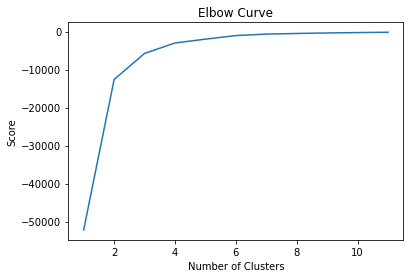

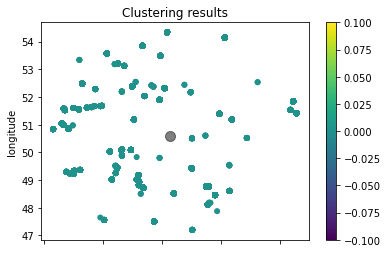

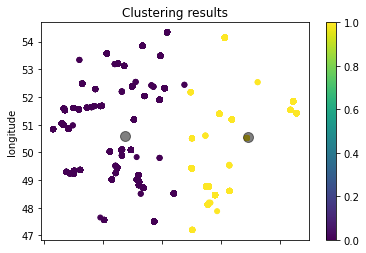

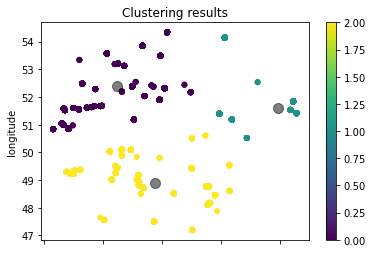

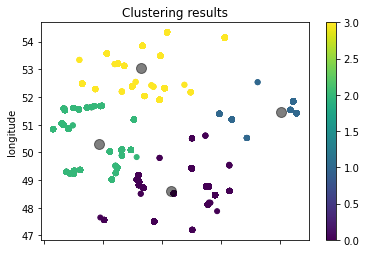

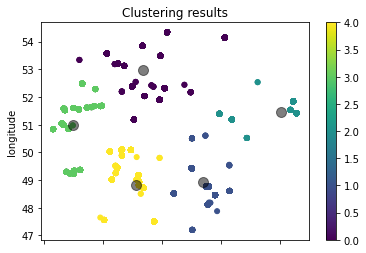

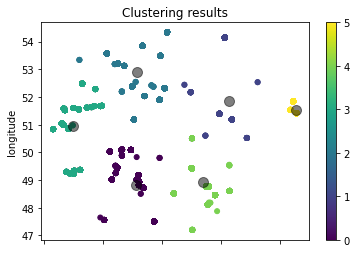

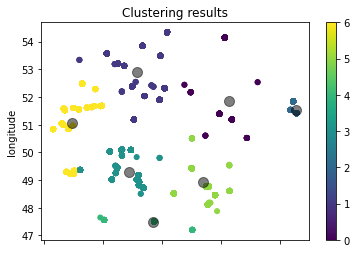

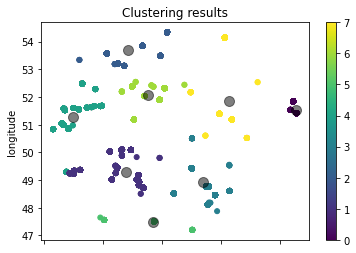

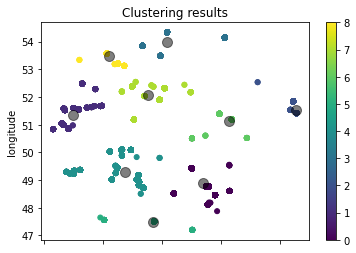

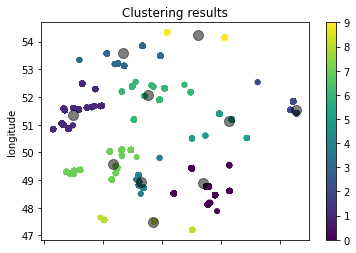

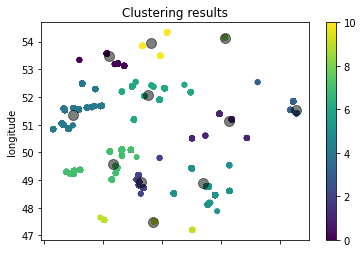

In [22]:
#### CLUSTER LOCATIONS: LOCATION CLUSTERS WITH MOST REDISPATCH OPERATIONS

df_rd_locations = df_rd[["BETROFFENE_ANLAGE","latitude","longitude"]].copy()
df_rd_locations.dropna(axis=0,how='any',subset=['latitude','longitude'],inplace=True)
df_rd_locations = df_rd_locations.drop(df_rd_locations[(df_rd_locations["latitude"] == 0) | (df_rd_locations["longitude"] == 0)].index).reset_index(drop=True)

# Prepare dataset for clustering
K_clusters = range(1,12)
kmeans_list = [KMeans(n_clusters=i, init ='k-means++') for i in K_clusters] 
Y_axis = df_rd_locations[['latitude']]
X_axis = df_rd_locations[['longitude']]

# Compute cluster score
score = [kmeans_list[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans_list))]

# Visualize score
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

## Perform clustering
for i in K_clusters:
    kmeans = KMeans(n_clusters = i, init ='k-means++')    
    kmeans.fit(df_rd_locations[df_rd_locations.columns[1:3]])
    df_rd_locations['cluster_label_{}'.format(i)] = kmeans.fit_predict(df_rd_locations[df_rd_locations.columns[1:3]])
    centers = kmeans.cluster_centers_
    labels = kmeans.predict(df_rd_locations[df_rd_locations.columns[1:3]])
    
    # Plot clustering results
    df_rd_locations.plot.scatter(x = 'longitude', y = 'latitude', c = labels, s = 25, cmap = 'viridis')
    plt.scatter(centers[:, 1], centers[:, 0], c = 'black', s = 100, alpha = 0.5, )
    plt.xlabel('latitude')
    plt.ylabel('longitude')
    plt.title('Clustering results')
    plt.show()

,BETROFFENE_ANLAGE,latitude,longitude,RAMP_UP
0,[Grosskraftwerk Mannheim AG],49.445694,8.490444,1
1,[Heizkraftwerk Heilbronn],49.176480,9.208574,1
2,[Heizkraftwerk Heilbronn],49.176480,9.208574,1
3,[Gebersdorf 2],49.420836,11.008794,1
4,[Vorarlberger Illwerke AG],47.500577,9.739870,1
...,...,...,...,...
8153,[Vorarlberger Illwerke AG],47.500577,9.739870,1
8154,[Vorarlberger Illwerke AG],47.500577,9.739870,1
8155,[Heizkraftwerk Altbach/Deizisau Block 2],48.720548,9.376593,1
8156,[Grosskraftwerk Mannheim AG],49.445694,8.490444,1


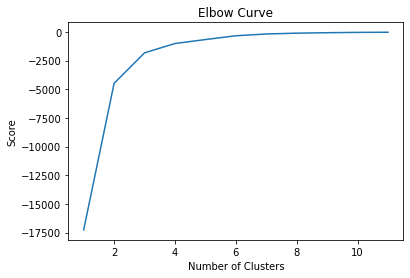

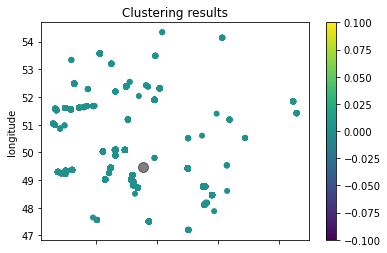

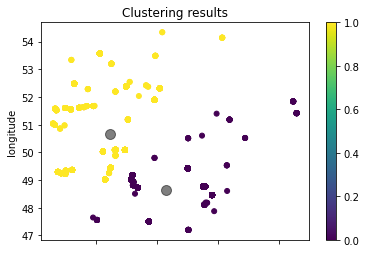

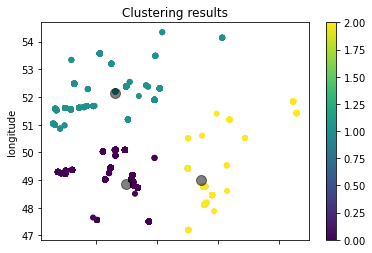

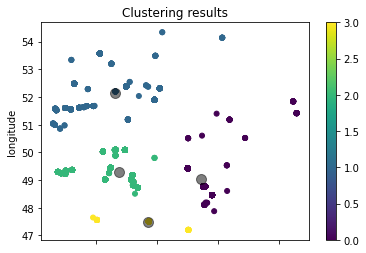

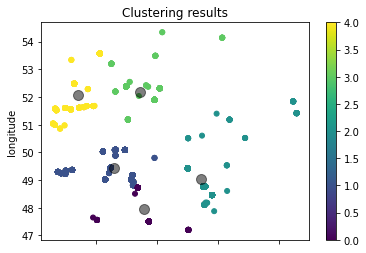

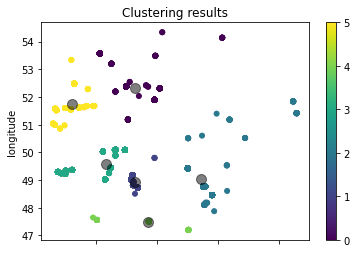

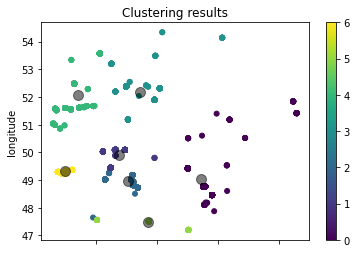

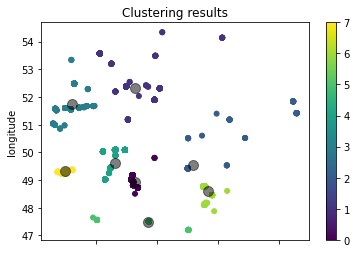

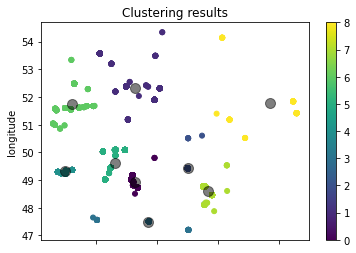

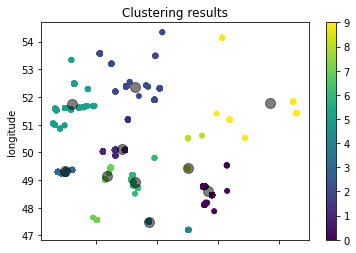

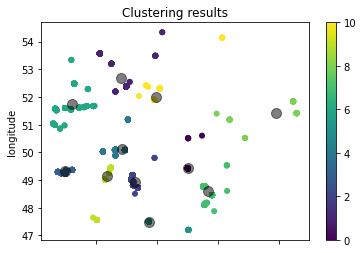

In [23]:
#### CLUSTER LOCATIONS: LOCATION CLUSTERS WITH MOST RAMPUP OPERATIONS

df_rd_locations_rampUp = df_rd[["BETROFFENE_ANLAGE","latitude","longitude","RAMP_UP"]].copy()
df_rd_locations_rampUp.dropna(axis=0,how='any',subset=['latitude','longitude'],inplace=True)
df_rd_locations_rampUp = df_rd_locations_rampUp.drop(df_rd_locations_rampUp[(df_rd_locations_rampUp["latitude"] == 0) | 
                                                                     (df_rd_locations_rampUp["longitude"] == 0) |
                                                                     (df_rd_locations_rampUp["RAMP_UP"] == 0)].index).reset_index(drop=True)
display(df_rd_locations_rampUp)
# Prepare dataset for clustering
K_clusters = range(1,12)
kmeans_list = [KMeans(n_clusters=i, init ='k-means++') for i in K_clusters] 
Y_axis = df_rd_locations_rampUp[['latitude']]
X_axis = df_rd_locations_rampUp[['longitude']]

# Compute cluster score
score = [kmeans_list[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans_list))]

# Visualize score
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

## Perform clustering
for i in K_clusters:
    kmeans = KMeans(n_clusters = i, init ='k-means++')    
    kmeans.fit(df_rd_locations_rampUp[df_rd_locations_rampUp.columns[1:3]])
    df_rd_locations_rampUp['cluster_label_{}'.format(i)] = kmeans.fit_predict(df_rd_locations_rampUp[df_rd_locations_rampUp.columns[1:3]])
    centers = kmeans.cluster_centers_
    labels = kmeans.predict(df_rd_locations_rampUp[df_rd_locations_rampUp.columns[1:3]])
    
    # Plot clustering results
    df_rd_locations_rampUp.plot.scatter(x = 'longitude', y = 'latitude', c = labels, s = 25, cmap = 'viridis')
    plt.scatter(centers[:, 1], centers[:, 0], c = 'black', s = 100, alpha = 0.5, )
    plt.xlabel('latitude')
    plt.ylabel('longitude')
    plt.title('Clustering results')
    plt.show()


,BETROFFENE_ANLAGE,latitude,longitude,RAMP_UP
0,"[Boxberg, Jaenschwalde, Schkopau, Schwarze Pumpe]",51.416300,14.561900,0
1,"[Jaenschwalde, Schwarze Pumpe]",51.840525,14.449482,0
2,[Moorburg],53.488612,9.951310,0
3,[Boxberg],51.416300,14.561900,0
4,"[Boxberg, Jaenschwalde, Moorburg, Schkopau, Sc...",51.416300,14.561900,0
...,...,...,...,...
7427,"[Boxberg, Jaenschwalde, Schwarze Pumpe]",51.416300,14.561900,0
7428,[Brokdorf],53.850833,9.344722,0
7429,[Kernkraftwerk Neckarwestheim Block 2],49.041024,9.172954,0
7430,[Kernkraftwerk Neckarwestheim Block 2],49.041024,9.172954,0


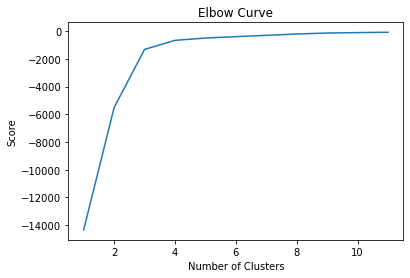

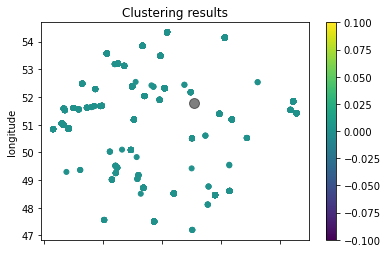

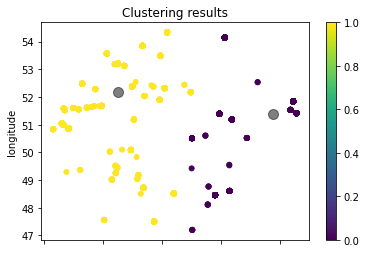

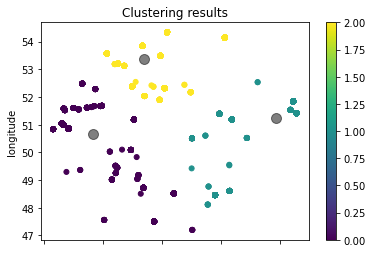

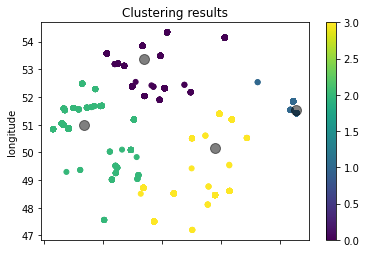

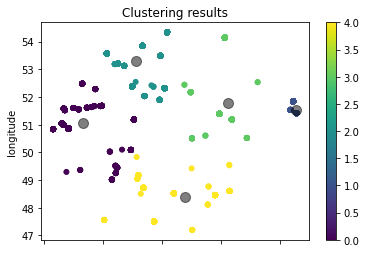

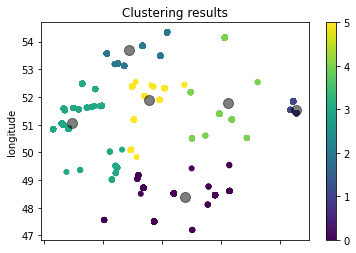

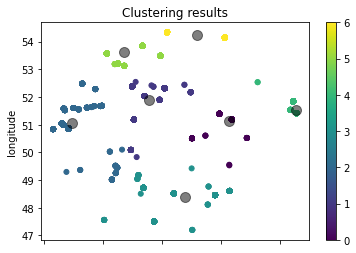

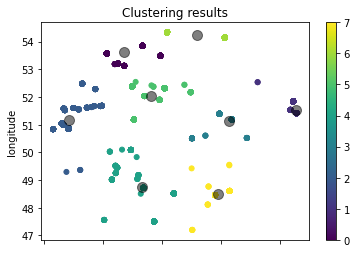

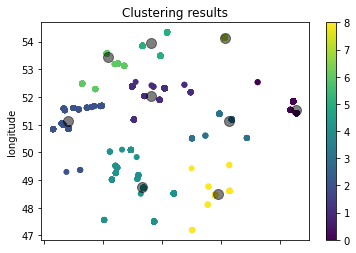

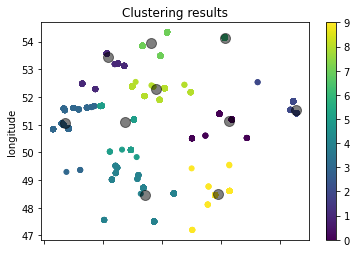

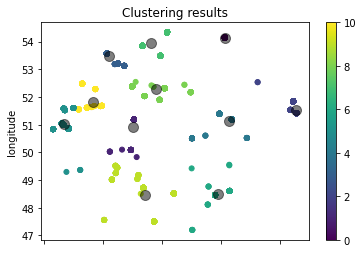

In [24]:
#### CLUSTER LOCATIONS: LOCATION CLUSTERS WITH MOST CURTAILMENT OPERATIONS

df_rd_locations_curtail = df_rd[["BETROFFENE_ANLAGE","latitude","longitude","RAMP_UP"]].copy()
df_rd_locations_curtail.dropna(axis=0,how='any',subset=['latitude','longitude'],inplace=True)
df_rd_locations_curtail = df_rd_locations_curtail.drop(df_rd_locations_curtail[(df_rd_locations_curtail["latitude"] == 0) | 
                                                                     (df_rd_locations_curtail["longitude"] == 0) |
                                                                     (df_rd_locations_curtail["RAMP_UP"] == 1)].index).reset_index(drop=True)
display(df_rd_locations_curtail)
# Prepare dataset for clustering
K_clusters = range(1,12)
kmeans_list = [KMeans(n_clusters=i, init ='k-means++') for i in K_clusters] 
Y_axis = df_rd_locations_curtail[['latitude']]
X_axis = df_rd_locations_curtail[['longitude']]

# Compute cluster score
score = [kmeans_list[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans_list))]

# Visualize score
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

## Perform clustering
for i in K_clusters:
    kmeans = KMeans(n_clusters = i, init ='k-means++')    
    kmeans.fit(df_rd_locations_curtail[df_rd_locations_curtail.columns[1:3]])
    df_rd_locations_curtail['cluster_label_{}'.format(i)] = kmeans.fit_predict(df_rd_locations_curtail[df_rd_locations_curtail.columns[1:3]])
    centers = kmeans.cluster_centers_
    labels = kmeans.predict(df_rd_locations_curtail[df_rd_locations_curtail.columns[1:3]])
    
    # Plot clustering results
    df_rd_locations_curtail.plot.scatter(x = 'longitude', y = 'latitude', c = labels, s = 25, cmap = 'viridis')
    plt.scatter(centers[:, 1], centers[:, 0], c = 'black', s = 100, alpha = 0.5, )
    plt.xlabel('latitude')
    plt.ylabel('longitude')
    plt.title('Clustering results')
    plt.show()

<AxesSubplot:>

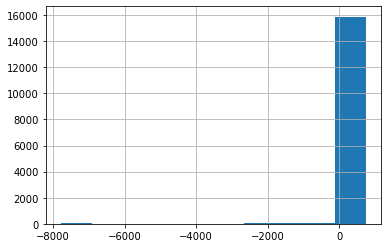

In [203]:
#### VIZUALIZATION OF DATA



df_rd["redispatch_duration"].astype('timedelta64[h]').hist()

,BETROFFENE_ANLAGE,x,y,cluster_label
0,[Grosskraftwerk Mannheim AG],49.445694,8.490444,1
1,[Heizkraftwerk Heilbronn],49.176480,9.208574,1
2,[Heizkraftwerk Heilbronn],49.176480,9.208574,1
3,[Gebersdorf 2],49.420836,11.008794,1
4,[Vorarlberger Illwerke AG],47.500577,9.739870,1
5,[Grosskraftwerk Mannheim AG],49.445694,8.490444,1
6,[Heizkraftwerk Heilbronn],49.176480,9.208574,1
7,"[Boxberg, Jaenschwalde, Schkopau, Schwarze Pumpe]",51.416300,14.561900,2
8,[Gebersdorf 2],49.420836,11.008794,1
9,[Zolling 5],48.456007,11.803449,1


8336